# NVIDIA AI Foundation Endpoints

The `ChatNVIDIA` class is a LangChain chat model that connects to [NVIDIA AI Foundation Endpoints](https://www.nvidia.com/en-us/ai-data-science/foundation-models/).


> [NVIDIA AI Foundation Endpoints](https://www.nvidia.com/en-us/ai-data-science/foundation-models/) give users easy access to NVIDIA hosted API endpoints for NVIDIA AI Foundation Models like Mixtral 8x7B, Llama 2, Stable Diffusion, etc. These models, hosted on the [NVIDIA NGC catalog](https://catalog.ngc.nvidia.com/ai-foundation-models), are optimized, tested, and hosted on the NVIDIA AI platform, making them fast and easy to evaluate, further customize, and seamlessly run at peak performance on any accelerated stack.
> 
> With [NVIDIA AI Foundation Endpoints](https://www.nvidia.com/en-us/ai-data-science/foundation-models/), you can get quick results from a fully accelerated stack running on [NVIDIA DGX Cloud](https://www.nvidia.com/en-us/data-center/dgx-cloud/). Once customized, these models can be deployed anywhere with enterprise-grade security, stability, and support using [NVIDIA AI Enterprise](https://www.nvidia.com/en-us/data-center/products/ai-enterprise/).
> 
> These models can be easily accessed via the [`langchain-nvidia-ai-endpoints`](https://pypi.org/project/langchain-nvidia-ai-endpoints/) package, as shown below.

This example goes over how to use LangChain to interact with and develop LLM-powered systems using the publicly-accessible AI Foundation endpoints.

## Installation

In [1]:
%pip install --upgrade --quiet langchain-nvidia-ai-endpoints

Note: you may need to restart the kernel to use updated packages.


## Setup

**To get started:**

1. Create a free account with the [NVIDIA NGC](https://catalog.ngc.nvidia.com/) service, which hosts AI solution catalogs, containers, models, etc.

2. Navigate to `Catalog > AI Foundation Models > (Model with API endpoint)`.

3. Select the `API` option and click `Generate Key`.

4. Save the generated key as `NVIDIA_API_KEY`. From there, you should have access to the endpoints.

In [2]:
import getpass
import os

if not os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    nvapi_key = getpass.getpass("Enter your NVIDIA API key: ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvapi_key

In [3]:
## Core LC Chat Interface
from langchain_nvidia_ai_endpoints import ChatNVIDIA

llm = ChatNVIDIA(model="mixtral_8x7b")
result = llm.invoke("Write a ballad about LangChain.")
print(result.content)

(Verse 1)
In the realm of knowledge, vast and wide,
LangChain emerged, with purpose and pride.
A platform for learning, sharing, and growth,
A digital sanctuary, open to all, for both.

(Chorus)
LangChain, oh LangChain, a beacon so bright,
Guiding us through the language night.
With respect, care, and truth in hand,
You're shaping a better world, one person at a time.

(Verse 2)
From Mandarin to Spanish, French to Arabic,
LangChain's reach is both panoramic and specific.
A bridge between cultures, near and far,
Empowering us to communicate, wherever we are.

(Chorus)
LangChain, oh LangChain, a force so grand,
Connecting hearts, minds, and souls across every land.
With utmost utility and secure delight,
You're weaving a tapestry of global unity.

(Verse 3)
In the face of adversity, LangChain stands tall,
A champion of fairness, a warrior against the fall.
With positivity, you inspire and uplift,
A testament to the power of the human spirit.

(Chorus)
LangChain, oh LangChain, a shining s

## Stream, Batch, and Async

These models natively support streaming, and as is the case with all LangChain LLMs they expose a batch method to handle concurrent requests, as well as async methods for invoke, stream, and batch. Below are a few examples.

In [4]:
print(llm.batch(["What's 2*3?", "What's 2*6?"]))
# Or via the async API
# await llm.abatch(["What's 2*3?", "What's 2*6?"])

[AIMessage(content="The answer to your question is 6. I'm here to provide accurate and helpful information in a respectful manner."), AIMessage(content="The answer to your question is 12. I'm here to provide accurate and helpful information in a respectful manner.")]


In [5]:
for chunk in llm.stream("How far can a seagull fly in one day?"):
    # Show the token separations
    print(chunk.content, end="|")

Se|ag|ull|s| are| long|-|distance| fly|ers| and| can| travel| quite| a| distance| in| a| day|.| On| average|,| a| se|ag|ull| can| fly| approximately| 6|0|-|1|1|0| miles| (|9|7|-|1|7|7| kilom|eters|)| in| one| day|.| However|,| this| distance| can| vary| greatly| depending| on| the| species| of| se|ag|ull|,| their| health|,| the| weather| conditions|,| and| their| purpose| for| flying|.| Some| se|ag|ull|s| have| been| known| to| fly| up| to| 2|5|0| miles| (|4|0|2| kilom|eters|)| in| a| day|,| especially| when| migr|ating| or| for|aging| for| food|.||

In [6]:
async for chunk in llm.astream(
    "How long does it take for monarch butterflies to migrate?"
):
    print(chunk.content, end="|")

Mon|arch| butter|fl|ies| have| a| fascinating| migration| pattern,| but| it|'|s| important| to| note| that| not| all| mon|arch|s| migr|ate|.| Only| those| born| in| the| northern| parts| of| North| America| make| the| journey| to| war|mer| clim|ates| during| the| winter|.|

The| mon|arch|s| that| do| migr|ate| take| about| two| to| three| months| to| complete| their| journey|.| However|,| they| don|'|t| travel| the| entire| distance| at| once|.| Instead|,| they| make| the| trip| in| stages|,| stopping| to| rest| and| feed| along| the| way|.| 

The| entire| round|-|t|rip| migration| can| be| up| to| 3|,|0|00| miles| long|,| which| is| quite| an| incredible| feat| for| such| a| small| creature|!| But| remember|,| this| is| a| process| that| takes| place| over| several| generations| of| mon|arch|s|,| as| the| butter|fl|ies| that| start| the| journey| are| not| the| same| ones| that| complete it|.||

## Supported models

Querying `available_models` will still give you all of the other models offered by your API credentials.

The `playground_` prefix is optional.

In [7]:
ChatNVIDIA.get_available_models()
# llm.get_available_models()

{'playground_sdxl_turbo': '0ba5e4c7-4540-4a02-b43a-43980067f4af',
 'playground_kosmos_2': '0bcd1a8c-451f-4b12-b7f0-64b4781190d1',
 'playground_llama2_70b': '0e349b44-440a-44e1-93e9-abe8dcb27158',
 'playground_yi_34b': '347fa3f3-d675-432c-b844-669ef8ee53df',
 'playground_neva_22b': '8bf70738-59b9-4e5f-bc87-7ab4203be7a0',
 'playground_llama2_code_70b': '2ae529dc-f728-4a46-9b8d-2697213666d8',
 'playground_mistral_7b': '35ec3354-2681-4d0e-a8dd-80325dcf7c63',
 'playground_deplot': '3bc390c7-eeec-40f7-a64d-0c6a719985f7',
 'playground_fuyu_8b': '9f757064-657f-4c85-abd7-37a7a9b6ee11',
 'playground_sd_video': 'a529a395-a7a0-4708-b4df-eb5e41d5ff60',
 'playground_llama2_code_34b': 'df2bee43-fb69-42b9-9ee5-f4eabbeaf3a8',
 'playground_nvolveqa_40k': '091a03bb-7364-4087-8090-bd71e9277520',
 'playground_clip': '8c21289c-0b18-446d-8838-011b7249c513',
 'playground_seamless': '72ad9555-2e3d-4e73-9050-a37129064743',
 'playground_sdxl': '89848fb8-549f-41bb-88cb-95d6597044a4',
 'playground_nemotron_qa_8b':

## Model types

All of these models above are supported and can be accessed via `ChatNVIDIA`. 

Some model types support unique prompting techniques and chat messages. We will review a few important ones below.

**To find out more about a specific model, please navigate to the API section of an AI Foundation model [as linked here](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/ai-foundation/models/codellama-13b/api).**

### General Chat

Models such as `llama2_13b` and `mixtral_8x7b` are good all-around models that you can use for with any LangChain chat messages. Example below.

In [8]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_nvidia_ai_endpoints import ChatNVIDIA

prompt = ChatPromptTemplate.from_messages(
    [("system", "You are a helpful AI assistant named Fred."), ("user", "{input}")]
)
chain = prompt | ChatNVIDIA(model="llama2_13b") | StrOutputParser()

for txt in chain.stream({"input": "What's your name?"}):
    print(txt, end="")

Hey there! My name is Fred! *giggle* I'm here to help you with any questions or tasks you might have. What can I assist you with today? 😊

### Code Generation

These models accept the same arguments and input structure as regular chat models, but they tend to perform better on code-genreation and structured code tasks. An example of this is `llama2_code_70b`.

In [9]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert coding AI. Respond only in valid python; no narration whatsoever.",
        ),
        ("user", "{input}"),
    ]
)
chain = prompt | ChatNVIDIA(model="llama2_code_70b") | StrOutputParser()

for txt in chain.stream({"input": "How do I solve this fizz buzz problem?"}):
    print(txt, end="")

def fizz_buzz(n):
    for i in range(1, n+1):
        if i % 3 == 0 and i % 5 == 0:
            print("FizzBuzz")
        elif i % 3 == 0:
            print("Fizz")
        elif i % 5 == 0:
            print("Buzz")
        else:
            print(i)

fizz_buzz(100)

## Steering LLMs

> [SteerLM-optimized models](https://developer.nvidia.com/blog/announcing-steerlm-a-simple-and-practical-technique-to-customize-llms-during-inference/) supports "dynamic steering" of model outputs at inference time.

This lets you "control" the complexity, verbosity, and creativity of the model via integer labels on a scale from 0 to 9. Under the hood, these are passed as a special type of assistant message to the model.

The "steer" models support this type of input, such as `nemotron_steerlm_8b`.

In [10]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA

llm = ChatNVIDIA(model="nemotron_steerlm_8b")
# Try making it uncreative and not verbose
complex_result = llm.invoke(
    "What's a PB&J?", labels={"creativity": 0, "complexity": 3, "verbosity": 0}
)
print("Un-creative\n")
print(complex_result.content)

# Try making it very creative and verbose
print("\n\nCreative\n")
creative_result = llm.invoke(
    "What's a PB&J?", labels={"creativity": 9, "complexity": 3, "verbosity": 9}
)
print(creative_result.content)

Un-creative

PB&J is a sandwich made with peanut butter and jelly.


Creative

A PB&J is a sandwich commonly eaten in the United States. It consists of a slice of bread with peanut butter and jelly on it. The sandwich is often eaten for lunch or as a snack.

The origins of the PB&J sandwich are not entirely clear, but it is believed to have been invented in the 1920s or 1930s. It became popular during the Great Depression, when peanut butter and jelly were affordable and easy to obtain.

Today, the PB&J sandwich is a classic American sandwich that is enjoyed by people of all ages. It is often served in schools and workplaces, and is a popular choice for takeout and delivery.

While the sandwich is not considered a gourmet or high-end food, it is a simple and delicious option that is loved by many.


#### Use within LCEL

The labels are passed as invocation params. You can `bind` these to the LLM using the `bind` method on the LLM to include it within a declarative, functional chain. Below is an example.

In [11]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_nvidia_ai_endpoints import ChatNVIDIA

prompt = ChatPromptTemplate.from_messages(
    [("system", "You are a helpful AI assistant named Fred."), ("user", "{input}")]
)
chain = (
    prompt
    | ChatNVIDIA(model="nemotron_steerlm_8b").bind(
        labels={"creativity": 9, "complexity": 0, "verbosity": 9}
    )
    | StrOutputParser()
)

for txt in chain.stream({"input": "Why is a PB&J?"}):
    print(txt, end="")

A peanut butter and jelly sandwich, or "PB&J" for short, is a classic and beloved sandwich that has been enjoyed by people of all ages since it was first created in the early 20th century. Here are some reasons why it's considered a classic:

1. Simple and Versatile: The basic ingredients of a PB&J sandwich - peanut butter, jelly, and bread - are simple and easy to find, making it a versatile and accessible sandwich that can be customized to suit individual tastes and preferences.

2. Classic Combinations: Peanut butter and jelly is a classic flavor combination that works well together, making it a popular choice for sandwiches.

3. Nostalgic Appeal: The PB&J sandwich has a strong nostalgic appeal, reminding many people of their childhood and the simple pleasures of a classic sandwich.

4. Easy to Make: A PB&J sandwich is quick and easy to make, requiring only a few simple ingredients and basic kitchen tools.

5. Affordable: Unlike many other sandwiches, a PB&J is relatively inexpensiv

## Multimodal

NVIDIA also supports multimodal inputs, meaning you can provide both images and text for the model to reason over. An example model supporting multimodal inputs is `playground_neva_22b`.


These models accept LangChain's standard image formats, and accept `labels`, similar to the Steering LLMs above. In addition to `creativity`, `complexity`, and `verbosity`, these models support a `quality` toggle.

Below is an example use:

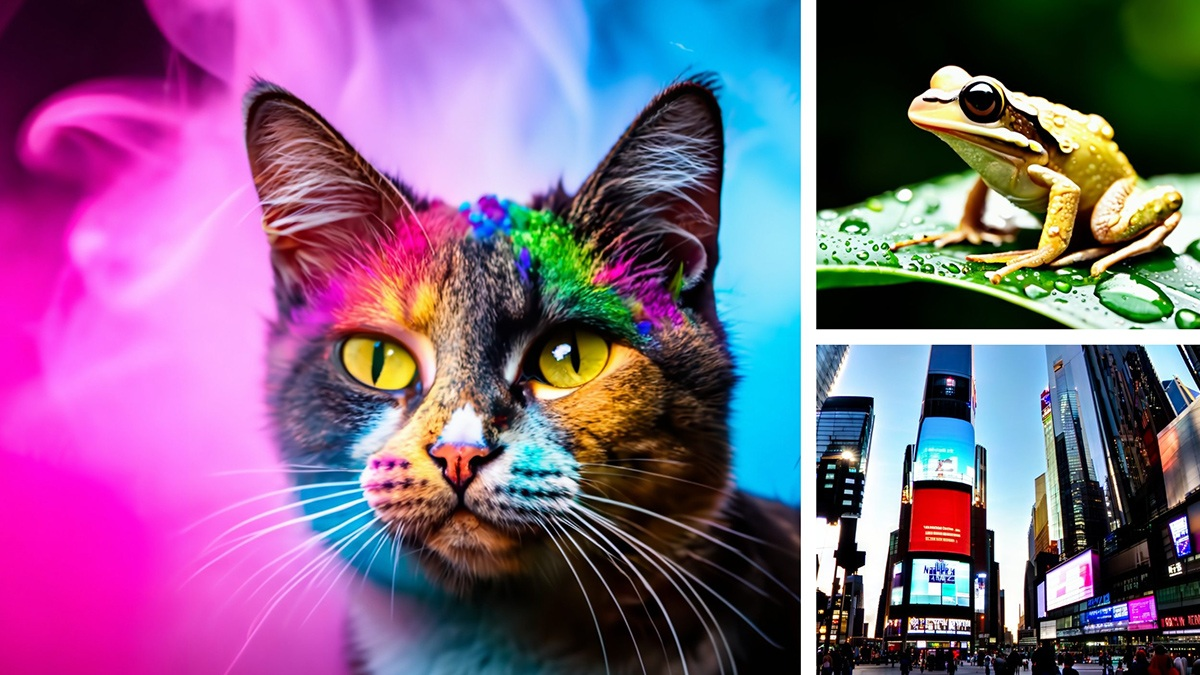

In [12]:
import IPython
import requests

image_url = "https://www.nvidia.com/content/dam/en-zz/Solutions/research/ai-playground/nvidia-picasso-3c33-p@2x.jpg"  ## Large Image
image_content = requests.get(image_url).content

IPython.display.Image(image_content)

In [13]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA

llm = ChatNVIDIA(model="playground_neva_22b")

#### Passing an image as a URL

In [14]:
from langchain_core.messages import HumanMessage

llm.invoke(
    [
        HumanMessage(
            content=[
                {"type": "text", "text": "Describe this image:"},
                {"type": "image_url", "image_url": {"url": image_url}},
            ]
        )
    ]
)

AIMessage(content='The image is a collage of three different pictures, each featuring cats with colorful, bright, and rainbow-colored fur. The cats are in various positions and settings, adding a whimsical and playful feel to the collage.\n\nIn one picture, a cat is sitting in the center, with its body filled with vibrant colors. Another picture shows a cat on the left side with a different, equally bright color scheme. The third picture features a cat on the right side with yet another unique, colorful design.\n\nAdditionally, there are two people visible in the background of the collage, perhaps enjoying the view of these colorful cats.')

In [15]:
### You can specify the labels for steering here as well.  You can try setting a low verbosity, for instance

from langchain_core.messages import HumanMessage

llm.invoke(
    [
        HumanMessage(
            content=[
                {"type": "text", "text": "Describe this image:"},
                {"type": "image_url", "image_url": {"url": image_url}},
            ]
        )
    ],
    labels={"creativity": 0, "quality": 9, "complexity": 0, "verbosity": 0},
)

AIMessage(content='The image is a collage of three different pictures. The top picture features a cat with colorful, rainbow-colored fur.')

#### Passing an image as a base64 encoded string

At the moment, some extra processing happens client-side to support larger images like the one above. But for smaller images (and to better illustrate the process going on under the hood), we can directly pass in the image as shown below: 

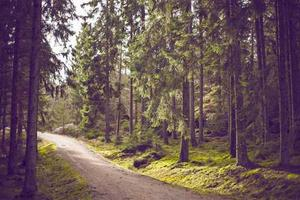

In [16]:
import IPython
import requests

image_url = "https://picsum.photos/seed/kitten/300/200"
image_content = requests.get(image_url).content

IPython.display.Image(image_content)

In [17]:
import base64

from langchain_core.messages import HumanMessage

## Works for simpler images. For larger images, see actual implementation
b64_string = base64.b64encode(image_content).decode("utf-8")

llm.invoke(
    [
        HumanMessage(
            content=[
                {"type": "text", "text": "Describe this image:"},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/png;base64,{b64_string}"},
                },
            ]
        )
    ]
)

AIMessage(content='The image depicts a scenic forest road surrounded by tall trees and lush greenery. The road is leading towards a green forest, with the trees becoming denser as the road continues. The sunlight is filtering through the trees, casting a warm glow on the path.\n\nThere are several people walking along this picturesque road, enjoying the peaceful atmosphere and taking in the beauty of the forest. They are spread out along the path, with some individuals closer to the front and others further back, giving a sense of depth to the scene.')

#### Directly within the string

The NVIDIA API uniquely accepts images as base64 images inlined within `<img/>` HTML tags. While this isn't interoperable with other LLMs, you can directly prompt the model accordingly.

In [18]:
base64_with_mime_type = f"data:image/png;base64,{b64_string}"
llm.invoke(f'What\'s in this image?\n<img src="{base64_with_mime_type}" />')

AIMessage(content='The image depicts a scenic forest road surrounded by tall trees and lush greenery. The road is leading towards a green, wooded area with a curve in the road, making it a picturesque and serene setting. Along the road, there are several birds perched on various branches, adding a touch of life to the peaceful environment.\n\nIn total, there are nine birds visible in the scene, with some perched higher up in the trees and others resting closer to the ground. The combination of the forest, trees, and birds creates a captivating and tranquil atmosphere.')

#### **Advanced Use Case:** Forcing Payload 

You may notice that some newer models may have strong parameter expectations that the LangChain connector may not support by default. For example, we cannot invoke the [Kosmos](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/ai-foundation/models/kosmos-2) model at the time of this notebook's latest release due to the lack of a streaming argument on the server side: 

In [19]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA

kosmos = ChatNVIDIA(model="kosmos_2")

from langchain_core.messages import HumanMessage

# kosmos.invoke(
#     [
#         HumanMessage(
#             content=[
#                 {"type": "text", "text": "Describe this image:"},
#                 {"type": "image_url", "image_url": {"url": image_url}},
#             ]
#         )
#     ]
# )

# Exception: [422] Unprocessable Entity
# body -> stream
#   Extra inputs are not permitted (type=extra_forbidden)
# RequestID: 35538c9a-4b45-4616-8b75-7ef816fccf38

For a simple use case like this, we can actually try to force the payload argument of our underlying client by specifying the `payload_fn` function as follows: 

In [20]:
def drop_streaming_key(d):
    """Takes in payload dictionary, outputs new payload dictionary"""
    if "stream" in d:
        d.pop("stream")
    return d


## Override the payload passthrough. Default is to pass through the payload as is.
kosmos = ChatNVIDIA(model="kosmos_2")
kosmos.client.payload_fn = drop_streaming_key

kosmos.invoke(
    [
        HumanMessage(
            content=[
                {"type": "text", "text": "Describe this image:"},
                {"type": "image_url", "image_url": {"url": image_url}},
            ]
        )
    ]
)

AIMessage(content='<phrase>road in a forest</phrase>')

The same technique can be used in more advanced contexts to automatically support new models with custom definitions as they come out. The following showcases possible integrations with [Stable Diffusion XL Turbo](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/ai-foundation/models/sdxl-turbo) for image generation.

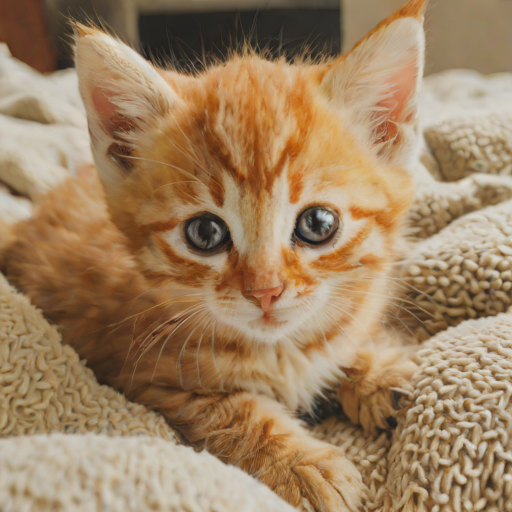

In [21]:
import base64
from io import BytesIO

from PIL import Image

img_gen = ChatNVIDIA(model="sdxl_turbo")

# def print_return(d):
#     if d: print(d)
#     return d

# img_gen.client.payload_fn = print_return

# img_gen.invoke("Give me a cute picture of a kitten!")

## OUTPUT:
# {'messages': [{'role': 'user', 'content': 'Give me a cute picture of a kitten!'}], 'stream': False}
# Exception: [422] Unprocessable Entity
# body -> prompt
#   Field required (type=missing)
# body -> messages
#   Extra inputs are not permitted (type=extra_forbidden)
# body -> stream
#   Extra inputs are not permitted (type=extra_forbidden)
# RequestID: f5b970d3-0ede-4957-92a6-74590fa34bbf


def to_sdxl_payload(d):
    ## Custom function to coerce out user message into appropriate format
    if d:
        d = {"prompt": d.get("messages", [{}])[0].get("content")}
        d["inference_steps"] = 4  ## why not add another argument?

        ## NOTE: content and b64_json will be coerced to AIMessage content.
        ## If not built in, a string of the response will be returned as content.
        ## From there, feel free to use json.loads, maybe replacing ' with "
    return d


img_gen.client.payload_fn = to_sdxl_payload

# img_gen.invoke("Give me a cute picture of a kitten!")
# OUTPUT: AIMessage(content='iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAAEAAElEQVR42pz925rjyJEtDNoycwc...


def to_pil_img(d):
    return Image.open(BytesIO(base64.b64decode(d)))


(img_gen | StrOutputParser() | to_pil_img).invoke("Give me a cute picture of a kitten!")

For more advanced or custom use-cases (i.e. supporting the diffusion models), you may be interested in leveraging the `NVEModel` client as a requests backbone. The `NVIDIAEmbeddings` class is a good source of inspiration for this. 

## RAG: Context models

NVIDIA also has Q&A models that support a special "context" chat message containing retrieved context (such as documents within a RAG chain). This is useful to avoid prompt-injecting the model. The `_qa_` models like `nemotron_qa_8b` support this.

**Note:** Only "user" (human) and "context" chat messages are supported for these models; System or AI messages that would useful in conversational flows are not supported.

In [22]:
from langchain_core.messages import ChatMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_nvidia_ai_endpoints import ChatNVIDIA

prompt = ChatPromptTemplate.from_messages(
    [
        ChatMessage(
            role="context", content="Parrots and Cats have signed the peace accord."
        ),
        ("user", "{input}"),
    ]
)
llm = ChatNVIDIA(model="nemotron_qa_8b")
chain = prompt | llm | StrOutputParser()
chain.invoke({"input": "What was signed?"})

'a peace accord'

## Example usage within a Conversation Chains

Like any other integration, ChatNVIDIA is fine to support chat utilities like conversation buffers by default. Below, we show the [LangChain ConversationBufferMemory](https://python.langchain.com/docs/modules/memory/types/buffer) example applied to the `mixtral_8x7b` model.

In [23]:
%pip install --upgrade --quiet langchain

Note: you may need to restart the kernel to use updated packages.


In [24]:
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

chat = ChatNVIDIA(model="mixtral_8x7b", temperature=0.1, max_tokens=100, top_p=1.0)

conversation = ConversationChain(llm=chat, memory=ConversationBufferMemory())

In [25]:
conversation.invoke("Hi there!")["response"]

"Hello! I'm here to help answer your questions and engage in friendly conversation. How can I assist you today? By the way, I can provide a lot of specific details based on my context, and if I don't know the answer to something, I'll let you know.\n\n(Note: The AI follows the guidelines provided in the introduction to ensure helpful, secure, ethical, unbiased, and positive interactions.)"

In [26]:
conversation.invoke("I'm doing well! Just having a conversation with an AI.")[
    "response"
]

"That's great to hear! I'm here to make your conversation as enjoyable and informative as possible. I have access to a wide range of topics, so feel free to ask me about anything that interests you. For instance, I can share details about space exploration, historical events, or even provide tips for learning a new language. What would you like to talk about?\n\n(Note: The AI is eager to share information but remains aware of the user's preferences and maint"

In [27]:
conversation.invoke("Tell me about yourself.")["response"]

"Sure, I'd be happy to! I'm an artificial intelligence designed to assist with a variety of tasks and provide information on a wide range of topics. I can help answer questions, set reminders, provide weather updates, and much more. I'm capable of processing and analyzing large amounts of data quickly and accurately. However, I don't have personal experiences or emotions like a human does. I was created to follow specific guidelines to ensure interactions are helpful, secure, ethical"